 IMPORT LIBRARIES

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve
from sklearn.preprocessing import LabelEncoder


LOAD DATA

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Fraud.csv to Fraud (1).csv


In [3]:
df=pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Basic check

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isna().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [6]:
# drop duplicated
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(6362620, 11)

In [8]:
df.drop(columns=['nameOrig','nameDest'],inplace=True)

 FEATURE ENGINEERING

In [9]:
df['balanceDiffOrig']=df['oldbalanceOrg']-df['newbalanceOrig']
df['balanceDiffDest']=df['newbalanceDest']-df['oldbalanceDest']

Encoding

In [10]:
le=LabelEncoder()
df['type']=le.fit_transform(df['type'])

In [11]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0,9839.64,0.0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0,1864.28,0.0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0,181.00,0.0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0,181.00,-21182.0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0,11668.14,0.0


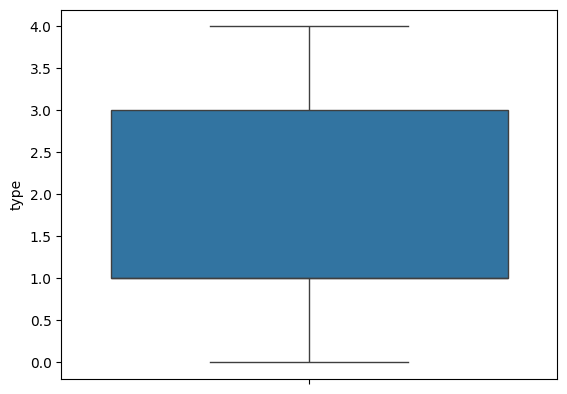

In [12]:
sns.boxplot(df['type'])
plt.show()

<Axes: ylabel='isFraud'>

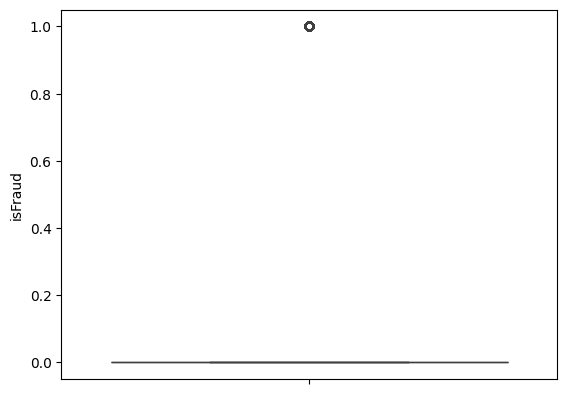

In [13]:
sns.boxplot(df['isFraud'])

In [14]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [15]:
X=df.drop(columns=['isFraud'])
y=df['isFraud']

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [17]:
rf=RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=5,class_weight='balanced',random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, random_state=42)

prdiction

In [30]:
y_pred=rf.predict(X_test)
y_prob=rf.predict_proba(X_test)[:,1]

MODEL EVALUATION

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.15      0.99      0.25      1643

    accuracy                           0.99   1272524
   macro avg       0.57      0.99      0.63   1272524
weighted avg       1.00      0.99      1.00   1272524



confusion matrix

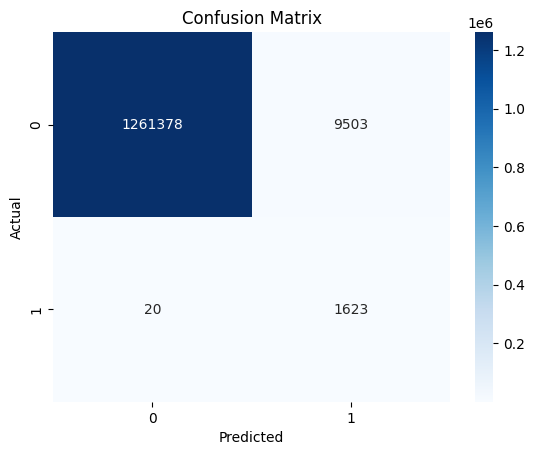

In [32]:
cm=confusion_matrix(y_test,y_pred)

sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

ROC-AUC SCORE

In [33]:
roc_auc=roc_auc_score(y_test,y_proba)
print("ROC-AUC SCORE:",roc_auc)

ROC-AUC SCORE: 0.999542666805021


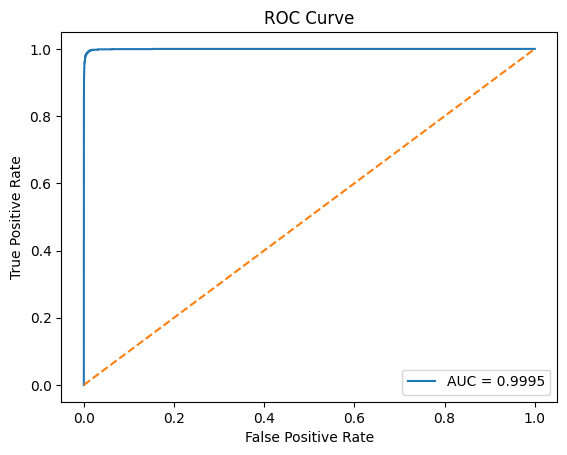

In [34]:
# ROC CURVE
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [35]:
#feature importance
feature_importance=pd.DataFrame({
    'feature':X.columns,
    'importance':rf.feature_importances_
}).sort_values(by='importance',ascending=False)

In [39]:
feature_importance.head(10)

,feature,importance
8,balanceDiffOrig,0.335428
3,oldbalanceOrg,0.180977
4,newbalanceOrig,0.138391
2,amount,0.105885
1,type,0.078825
9,balanceDiffDest,0.069403
0,step,0.047014
6,newbalanceDest,0.030685
5,oldbalanceDest,0.012093
7,isFlaggedFraud,0.001300


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'balanceDiffOrig'),
  Text(1, 0, 'oldbalanceOrg'),
  Text(2, 0, 'newbalanceOrig'),
  Text(3, 0, 'amount'),
  Text(4, 0, 'type'),
  Text(5, 0, 'balanceDiffDest'),
  Text(6, 0, 'step'),
  Text(7, 0, 'newbalanceDest'),
  Text(8, 0, 'oldbalanceDest'),
  Text(9, 0, 'isFlaggedFraud')])

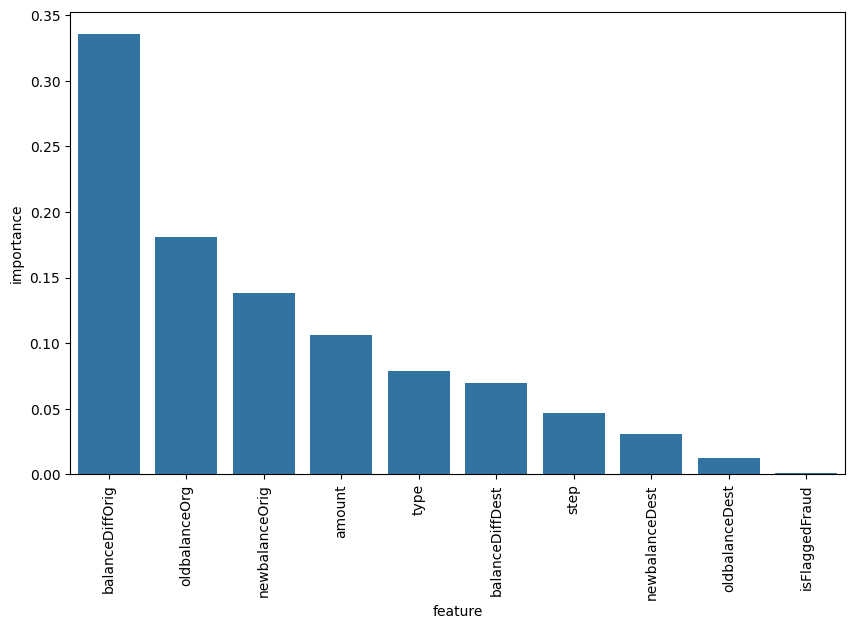

In [40]:
#Plot Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x='feature',y='importance',data=feature_importance)
plt.xticks(rotation=90)

In [41]:
#save model
import joblib
joblib.dump(rf,'fraud_detection_model.pkl')

['fraud_detection_model.pkl']